In [9]:
import math
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import numba
from numba import njit
import time
from matplotlib.pyplot import figure
# !pip install ortools
# import ortools

# from ortools.constraint_solver import routing_enums_pb2

# from ortools.constraint_solver import pywrapcp
from numba.typed import List
from collections import defaultdict

In [10]:
n = 200
item_list= []
for i in range(n//4):
    a= rd.randint(20,30)
    b= rd.randint(20,30)
    item_list.append(np.array([a,b], np.int_))
for i in range(n//4):
    a= rd.randint(50,80)
    b= rd.randint(10,20)
    item_list.append(np.array([a,b], np.int_))
for i in range(n//4):
    a= rd.randint(20,30)
    b= rd.randint(80,90)
    item_list.append(np.array([a,b], np.int_))
for i in range(n//4):
    a= rd.randint(70,90)
    b= rd.randint(80,90)
    item_list.append(np.array([a,b], np.int_))
item_list = np.array( item_list, np.int_)
min_width = min([item[1] for item in item_list])
bin_length = 1200
bin_width = 500

In [11]:
PI_X = 2
PI_Y = 3
PI_LENGTH = 0
PI_WIDTH = 1

In [12]:
def split(s,item_list):
    total = bin_width
    max_length = 0
    count = 0
    pv_x=0
    pv_y=0
    list_bin = np.empty((0, 5), np.int_)
    reverse = False
    new_list_item = [[]]
    for i in range(len(s)):
        change = False
        for j  in range(len(list_bin)):
          if list_bin[j][1] >= item_list[s[i], 1] and list_bin[j][0] >= item_list[s[i], 0]:
              if list_bin[j][4]%2 == 1:
                  new_list_item[list_bin[j][4]].insert(0, np.array([item_list[s[i],0], item_list[s[i],1], list_bin[j][2], list_bin[j][3]-item_list[s[i],1]], np.int_))
                  list_bin[j][:] = [list_bin[j][0], list_bin[j][1] - item_list[s[i],1], list_bin[j][2], list_bin[j][3]  - item_list[s[i],1], list_bin[j][4]]
              else:
                  new_list_item[list_bin[j][4]].append(np.array([item_list[s[i],0], item_list[s[i], 1], list_bin[j][2], list_bin[j][3]], np.int_))
                  list_bin[j][:] = [list_bin[j][0], list_bin[j][1] - item_list[s[i],1], list_bin[j][2], list_bin[j][3] + item_list[s[i],1], list_bin[j][4]]
              if list_bin[j][1] < min_width:
                  new_list_bin = np.empty((len(list_bin) - 1, 5), np.int_)
                  new_list_bin[:j] = list_bin[:j]
                  new_list_bin[j:] = list_bin[j+1:]
                  list_bin = new_list_bin
              change = True
              break
        if change: continue
        if total >= item_list[s[i],1]:
            total-= item_list[s[i],1]
            if reverse:
                pv_y -= item_list[s[i],1]
                new_list_item[-1].insert(0,np.array([item_list[s[i],0], item_list[s[i], 1], pv_x, pv_y], np.int_))
            else:
                new_list_item[-1].append(np.array([item_list[s[i],0], item_list[s[i], 1], pv_x, pv_y], np.int_))
                pv_y += item_list[s[i],1]
            if max_length < item_list[s[i],0]:
                max_length =  item_list[s[i],0]
        else:
            if total >= min_width:
                new_list_bin = np.empty((len(list_bin) + 1, 5), np.int_)
                new_list_bin[:-1] = list_bin
                new_list_bin[-1] = np.array([max_length, total,pv_x,pv_y,count], np.int_)
                list_bin = new_list_bin
            count += 1
            total = bin_width - item_list[s[i],1]
            pv_x += max_length
            if not reverse:
                pv_y = bin_width - item_list[s[i],1]
                new_list_item.append([np.array([item_list[s[i],0], item_list[s[i], 1], pv_x, pv_y], np.int_)])
                reverse = True
            else:
                new_list_item.append([np.array([item_list[s[i],0], item_list[s[i], 1], pv_x, 0], np.int_)])
                pv_y = item_list[s[i],1]
                reverse = False
            max_length = item_list[s[i],0]
    item_list = []
    for x in new_list_item: item_list.extend(x)
    item_list = np.array(item_list, np.int_)
    return item_list

In [13]:
@njit
def check_over_lap(p1, y1, p2, y2):
    if p1>=p2+y2:
        return False
    if p1+y1<=p2:
        return False
    return True

In [14]:
@njit
def shaking_items(item_list, invert, shaking_direction, shaking_zone = np.array([10000000, 10000000, 0, 0]), static_zone = np.array([0, 0, -1, -1], np.int_)):
    if not invert:item_list = item_list[np.argsort(item_list[:,PI_LENGTH + shaking_direction] + item_list[:,PI_X + shaking_direction])]
    elif invert: item_list = item_list[np.argsort(-item_list[:,PI_LENGTH + shaking_direction] - item_list[:,PI_X + shaking_direction])]
    for i in range(len(item_list)):
        if item_list[i][PI_X] < shaking_zone[PI_X] or item_list[i][PI_X] > shaking_zone[PI_X] + shaking_zone[PI_LENGTH] or item_list[i][PI_Y] < shaking_zone[PI_Y] or item_list[i][PI_Y] > shaking_zone[PI_Y] + shaking_zone[PI_WIDTH]:
          continue
        if item_list[i][PI_X] >= static_zone[PI_X] and item_list[i][PI_X] <= static_zone[PI_X] + static_zone[PI_LENGTH] and item_list[i][PI_Y] >= static_zone[PI_Y] and item_list[i][PI_Y] <= static_zone[PI_Y] + static_zone[PI_WIDTH]:
          continue
        if not invert: new_pos=0
        elif invert:
          if shaking_direction == 0:
            new_pos = bin_length  - item_list[i][PI_LENGTH]
          elif shaking_direction == 1:
            new_pos = bin_width  - item_list[i][PI_WIDTH]
        for j in range(i):
            if not invert:
              if check_over_lap(item_list[i][PI_Y - shaking_direction],item_list[i][PI_WIDTH - shaking_direction], item_list[j][PI_Y - shaking_direction],item_list[j][PI_WIDTH - shaking_direction]):
                  new_pos= max(item_list[j][PI_X + shaking_direction]+ item_list[j][PI_LENGTH + shaking_direction], new_pos)
            elif invert:
              if check_over_lap(item_list[i][PI_Y - shaking_direction],item_list[i][PI_WIDTH - shaking_direction], item_list[j][PI_Y - shaking_direction],item_list[j][PI_WIDTH - shaking_direction]):
                  new_pos= min(item_list[j][PI_X + shaking_direction]- item_list[i][PI_LENGTH + shaking_direction], new_pos)
        item_list[i][PI_X + shaking_direction]= new_pos
    return item_list

In [15]:
from matplotlib.patches import Rectangle
def rec(x,y,l,w,color):
    rec= Rectangle((x,y),l,w,linewidth=1,edgecolor='r',facecolor=color)
    plt.gca().add_patch(rec)
from matplotlib.pyplot import figure
def split_draw(item_list):
    figure(figsize=(8, 16), dpi=80)
    plt.gca().set_aspect('equal')

    plt.plot(bin_length, bin_width, "ro")
    rec(x=0,y=0,l=bin_length,w=bin_width,color="none")
    for item in item_list:
      rec(x=item[2],y=item[3],l=item[0],w=item[1],color="blue")

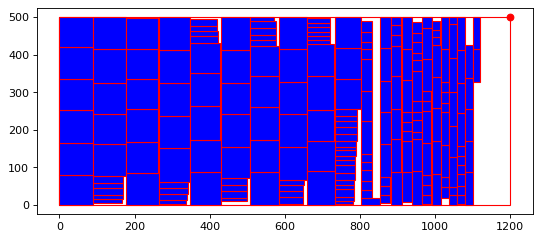

In [16]:
A= list(range(len(item_list)))
A.sort(key= lambda x:-item_list[x][0])
s = np.array(A, np.int_)
item_list = split(s,item_list)
split_draw(item_list)

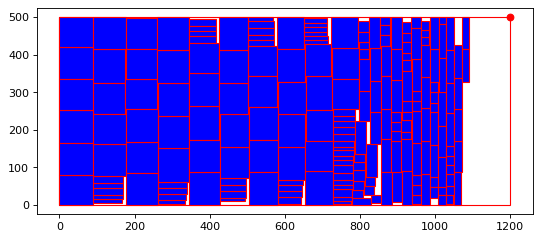

In [17]:
item_list= shaking_items(item_list, 0, 0, np.array([10000000, 10000000, 0, 0]), np.array([0, 0, -1, -1], np.int_))
split_draw(item_list)